In [1]:
%load_ext autoreload


In [2]:
from ibm_estimator import IBMEstimator
from vdd import VDD
from ncd import NCD
import heapq
from fscore import FScore

In [3]:
ENGLISH_PATH = "../mt/english-senate-0.txt"
FRENCH_PATH = "../mt/french-senate-0.txt"
TEST_ENGLISH_PATH = "../mt/english-senate-2.txt"
TEST_FRENCH_PATH = "../mt/french-senate-2.txt"
FRENCH_ENGLISH_MODEL = "model/french_to_english.json"
ENGLISH_FRENCH_MODEL = "model/english_to_french.json"
NCD_OUTPUT = "../mt/english-translation-ncd.txt"
VDD_OUTPUT = "../mt/english-translation-vdd.txt"

# IBM Estimator

Training IBM Estimator with Documents: This will take a while...


In [4]:
ibm_estimator = IBMEstimator.from_file(ENGLISH_PATH, FRENCH_PATH)
ibm_estimator.train()


Files Loaded
:Iteration 1 out of 10


KeyboardInterrupt: 

Getting the taus from the model we have stored. This is similar to the previous training for 10 iterations

In [5]:
ibm_estimator = IBMEstimator.from_json(FRENCH_ENGLISH_MODEL)

### One Word and Its Translation

In [6]:
word = "criminel"
translated_word = ibm_estimator.translate(word)

print("Original Word: ", word)
print("Translated Word: ", translated_word)

Original Word:  criminel
Translated Word:  criminal


### Top Five Possible Translations and Their Taus

In [7]:
word = ","
taus_word = ibm_estimator.taus.get_word_values(word)
taus_word = heapq.nlargest(5, taus_word, key=taus_word.get)
for dest in taus_word:
    taus = ibm_estimator.get_tau_from_pair((dest, word))
    print(dest, taus)

, 0.6444788285316682
LATE 0.48832479174071636
oh 0.483584989781956
36 0.4323556135411334
th 0.4307887286180639


### Five Words and Their Translation

In [8]:
words = ["Jeux", ",", ".", "talent", "criminel"]
for word in words:
    translated_word = ibm_estimator.translate(word)
    print("Original Word: ", word)
    print("Translated Word: ", translated_word)
    print()

Original Word:  Jeux
Translated Word:  Games

Original Word:  ,
Translated Word:  ,

Original Word:  .
Translated Word:  .

Original Word:  talent
Translated Word:  talent

Original Word:  criminel
Translated Word:  criminal



# Very Dumb Decoder

In [9]:
%reload_ext autoreload

In [10]:
ibm_estimator = IBMEstimator.from_json(FRENCH_ENGLISH_MODEL)
ibm_estimator.translate("débats")

'debates'

In [11]:
dumb_decoder = VDD()
dumb_decoder.ibm_estimator = ibm_estimator

### Translate One Sentence

In [12]:

with open(TEST_FRENCH_PATH, mode="r", encoding="latin-1") as fp:
        french_data_lst = fp.readlines()
TEST_FRENCH_SENTENCE = french_data_lst[0]
translated = dumb_decoder.translate_sentence(TEST_FRENCH_SENTENCE)

print("Original Sentence:", TEST_FRENCH_SENTENCE)
print("Translated:", translated)

Original Sentence: débats de le Sénat ( hansard ) 

Translated: debates de M. Senate ( Hansard ) 



### Translate Document

Decoding the entire French Document from the Test File. This takes around 2 mins.

In [13]:
dumb_decoder.decode_document(TEST_FRENCH_PATH)
dumb_decoder.decoded

# Noisy Channel Decoder

In [4]:
with open(FRENCH_PATH, mode="r", encoding="latin-1") as fp:
    french_data_lst = fp.readlines()
eng_to_fre = IBMEstimator.from_json(FRENCH_ENGLISH_MODEL)
fre_to_eng = IBMEstimator.from_json(FRENCH_ENGLISH_MODEL)
noisy_decoder = NCD()
dumb_decoder = VDD()
dumb_decoder.ibm_estimator = fre_to_eng
noisy_decoder.build_bigram(ENGLISH_PATH)

In [5]:
noisy_decoder.eng_to_french_estimator = eng_to_fre
noisy_decoder.french_to_eng_estimator = fre_to_eng
# prev: Eats
# French - pain:: Translations: Bread, Train, Dog, Socks, ->  tau(bread, pain)  ->taus: 0.6, 0.5, 0.4, 0.3 * bigram (eats, curr_word) -> 0.6*0.8, 0.5*0.6, 0.4*0.4, 0.3*0.1

### Translate Sentence

In [6]:
with open(TEST_FRENCH_PATH, encoding="latin-1") as fp:
    french_test_data = fp.readlines()
TEST_SENTENCE = french_test_data[40]

In [7]:
TEST_SENTENCE

'nous pouvons certainement demander à tous de parler dans les deux langues officielles . \n'

In [8]:
dumb_decoder.translate_sentence(TEST_SENTENCE)

'us indiscriminate certainly ask le all de speak streets des two languages Official . \n'

In [9]:
noisy_decoder.translate_sentence(TEST_SENTENCE)

'we can certainly ask to all of speak contained people two languages Official .'

In [10]:
with open(TEST_ENGLISH_PATH, encoding="latin-1") as fp:
    french_test_data = fp.readlines()
EXPECTED_ENGLISH = french_test_data[40]

In [11]:
EXPECTED_ENGLISH


'we can certainly ask everyone to speak in both official languages . \n'

### Decoding Document

Short Version of the French Test File... 

In [24]:
SHORT_FRENCH_PATH = "tests/test_data/test_french-senate-2.txt"
SHORT_ENGLISH_PATH = "tests/test_data/test_english-senate-2.txt"

Decoding the entire document takes around 4 mins depending on the Tau Cut off. You can change the tau cutt off by setting noisy_decoder.THRESHOLD to a higher number for faster and lower number for slower but more precise output. 

Warning very low thresholds take up to 40 mins to decode the document.

In [12]:
noisy_decoder.decode_document(TEST_FRENCH_PATH)

In [13]:
noisy_decoder.to_file("tests/test_data/final-english-translation-ncd.txt")

# F Score

In [25]:
fscore = FScore.from_file(TEST_ENGLISH_PATH, VDD_OUTPUT)
fscore.build()
fscore.calculate()

0.4001804453132552

In [14]:
fscore = FScore.from_file(TEST_ENGLISH_PATH, "tests/test_data/final-english-translation-ncd.txt")
fscore.build()
fscore.calculate()

0.5256758643652729

# Extra Credit

In [27]:
import numpy as np
import matplotlib.pyplot as plt

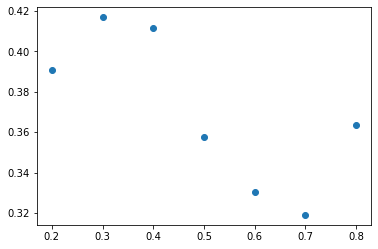

In [29]:

sequence = list(np.arange(0.2, 0.9, 0.1))
fscores = []
for i, epsilon in enumerate(sequence):
    noisy_decoder.decode_document(SHORT_FRENCH_PATH)
    noisy_decoder.THRESHOLD = epsilon
    noisy_decoder.to_file(f"../out/test-{i+1}-e{epsilon}.txt")


for i, epsilon in enumerate(sequence):
    fscore = FScore.from_file(SHORT_ENGLISH_PATH, f"../out/test-{i+1}-e{epsilon}.txt")
    fscore.build()
    f = fscore.calculate()
    fscores.append(f)
    

xpoints = np.array(sequence)
ypoints = np.array(fscores)  
plt.plot(xpoints, ypoints, 'o')
plt.show()


In [ ]:
x = range(1, 2)
list(x)

In [ ]:
sequence = list(np.arange(0.25, 1, 0.25))
print(sequence)

In [14]:
with open(TEST_FRENCH_PATH, encoding="latin-1") as fp:
    french_test_data = fp.readlines()
    
french_test_data[0]

'débats de le Sénat ( hansard ) \n'